In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare_data
import matplotlib.colors

In [2]:
data_dir = 'datasets/RetrospectivePatients/id004_bj'
results_dir = 'results/exp10/exp10.65.3/id004_bj'
meta_data_fname = 'BJcrise1le161128B-BEX_0002.json'
raw_seeg_fname = 'BJcrise1le161128B-BEX_0002.raw.fif'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
data, params_init = retro_prepare_data.prepare_data_stan(data_dir, meta_data_fname, raw_seeg_fname, 10, 0.04)

Isotrak not found


In [4]:
data['slp'] = data['slp'][0:-1:1024]
data['snsr_pwr'] = (data['slp']**2).sum(axis=0)
data['snsr_pwr'] = data['snsr_pwr']/data['snsr_pwr'].max()
data['nt'] = data['slp'].shape[0]
data['eps_snsr_pwr'] = 0.001

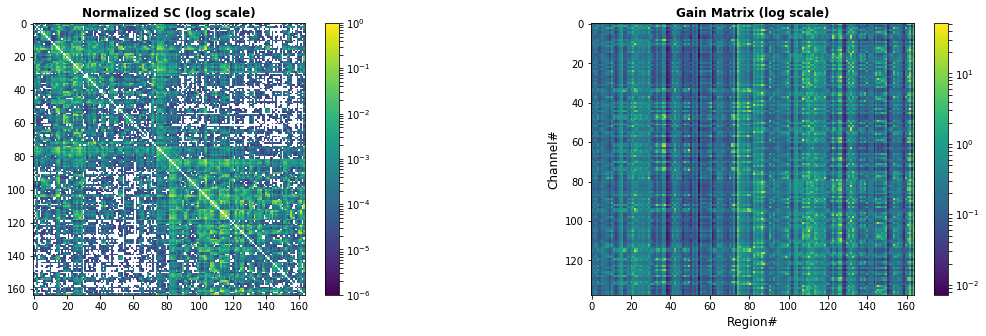

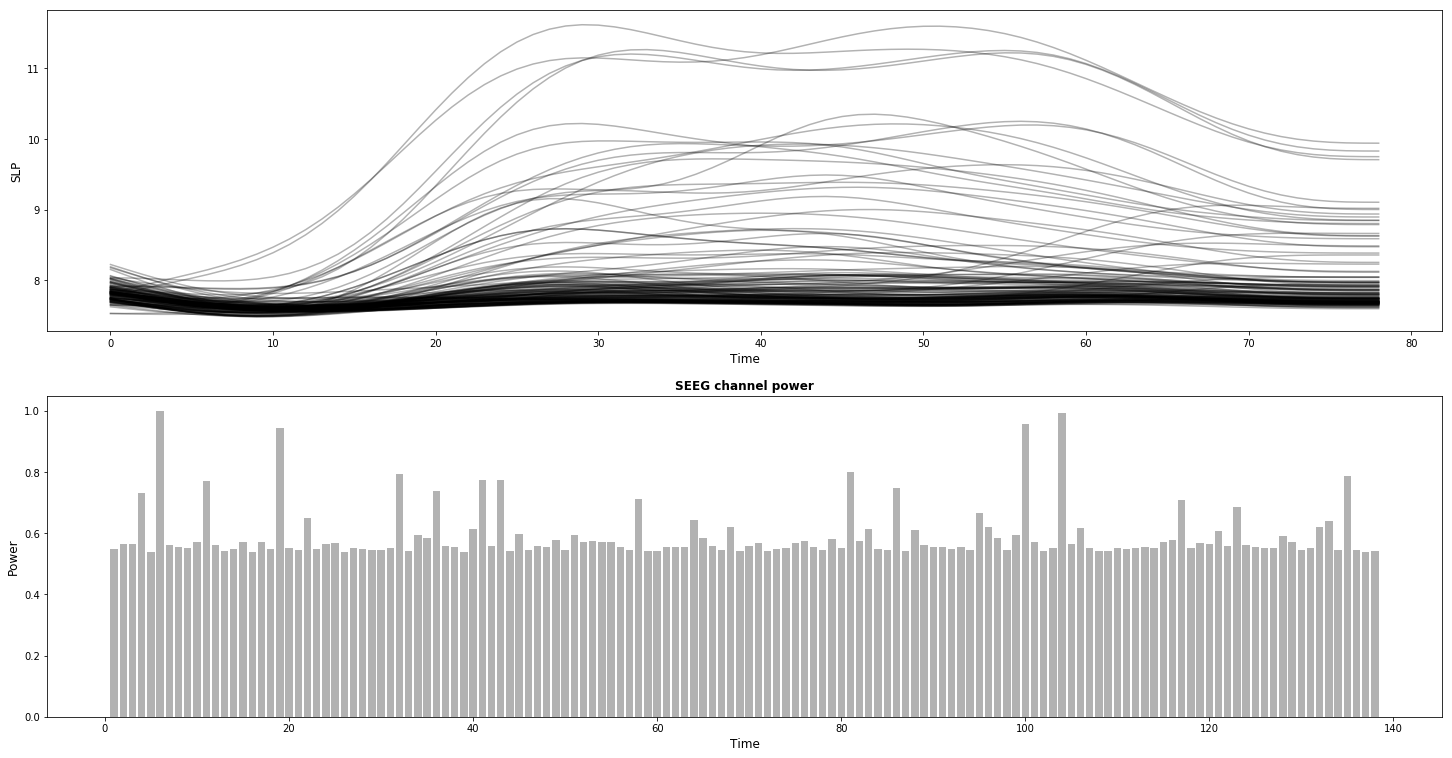

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target.png')
# plt.tight_layout()


In [6]:
stan_fname = 'exp10.65.3'

param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',params_init)


max_depth = 15
delta= 0.95
fname_suffix = f'md{max_depth}_delta{delta}_hyper_fixed'

input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [7]:
%%bash -s "$stan_fname"
~/.local/bin/stancompile.sh $1

/home/anirudh/hdisk/Academia/projects/vep.stan
make: '/home/anirudh/hdisk/Academia/projects/vep.stan/exp10.65.3' is up to date.


In [8]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix" "$max_depth" "$delta"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
MAX_DEPTH=$5
DELTA=$6

for i in {18..19};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=500 num_warmup=500 \
save_warmup=1 adapt delta=${DELTA} algorithm=hmc engine=nuts max_depth=${MAX_DEPTH} \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

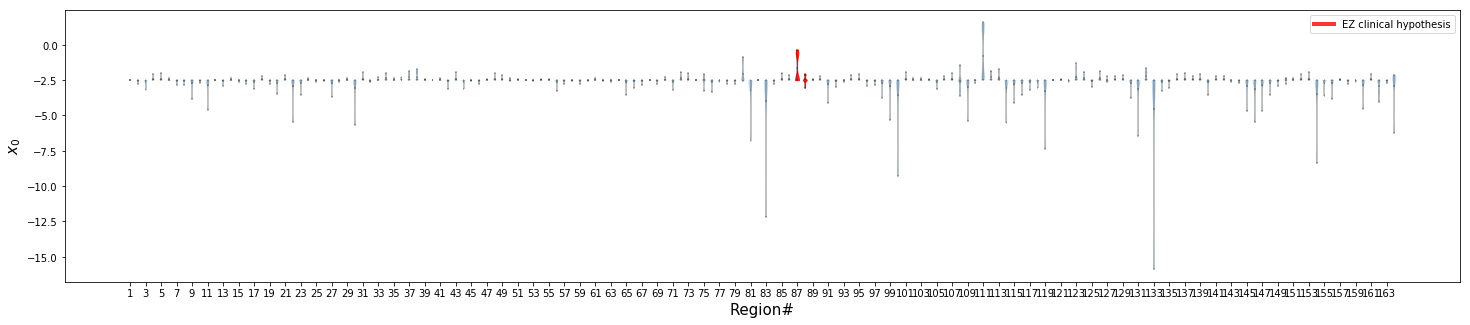

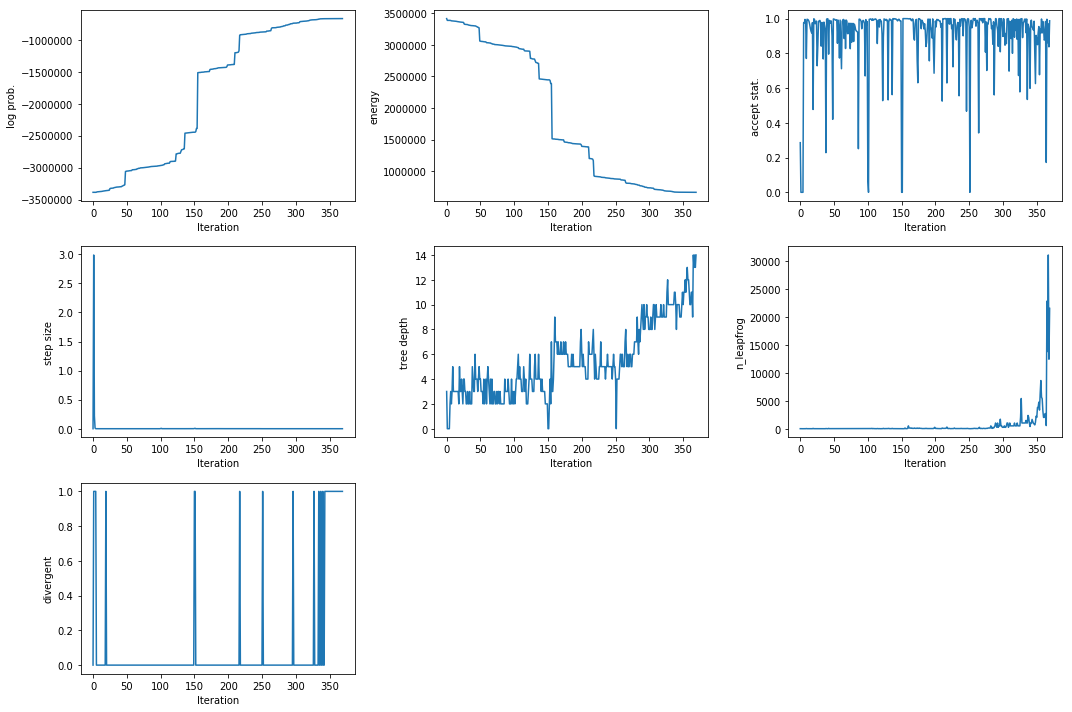

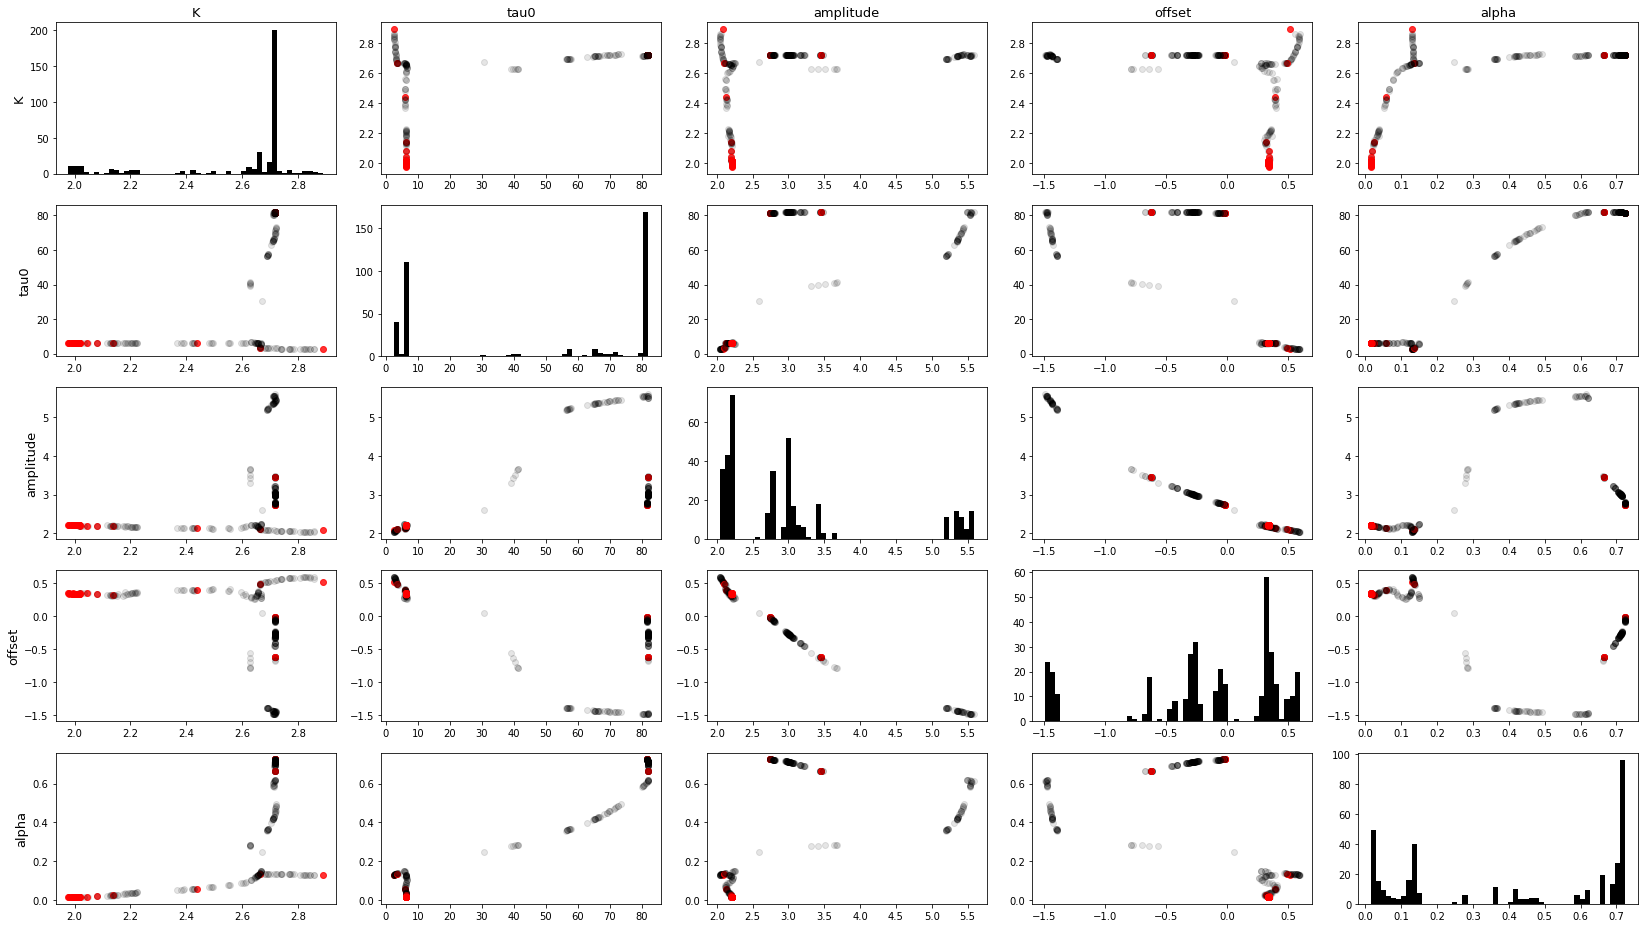

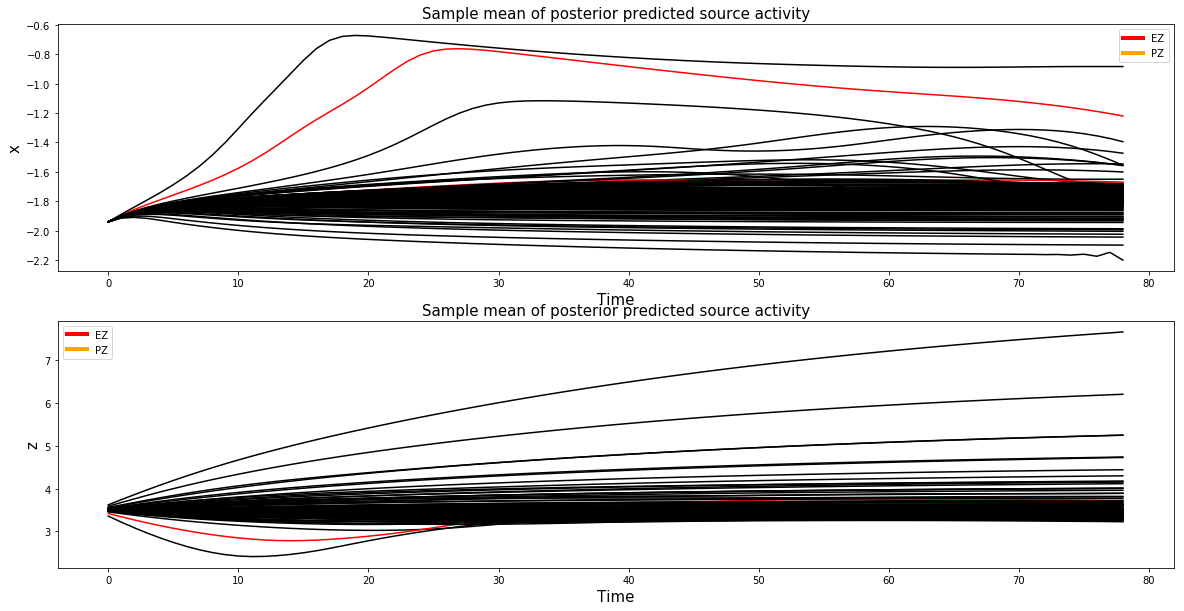

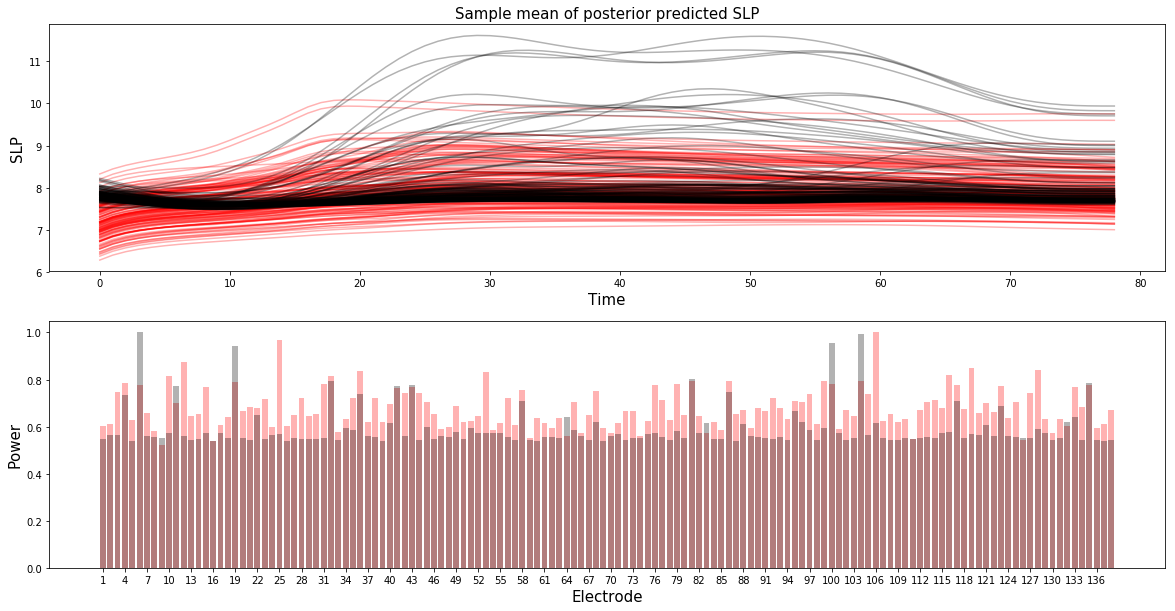

In [9]:
# import importlib
# importlib.reload(lib.plots.stan)

ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
chains = [18]
nwarmup = [370]
nsampling = [0]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'],nwarmup=nwarmup[i-1],nsampling=nsampling[i-1])
    lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(pstr_samples, ['K', 'tau0', 'amplitude', 'offset', 'alpha'],
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png', sampler='HMC')
    lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, [],
                               figname=f'{results_dir}/figures/posterior_predicted_src_chain{chain_no}.png')
    lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                   data, figname=f'{results_dir}/figures/posterior_predicted_slp_chain{chain_no}.png')

